## Set Up

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Hiển thị toàn bộ các cột
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv(r'/content/drive/MyDrive/Cuối kỳ/train.csv')

In [ ]:
#df=pd.read_csv(r'train.csv')

In [ ]:
df.sample(5)

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
41178,54716,1,D3,26,0.230769,2,1,1,0.298507,0.654545,0.284519,0.518420,0.055,9,1,0.0,2,0.00,1,2,8,2,1,2,1,2,1,1,3,NaN,3,2,3,2,0.376812,NaN,0.338028,NaN,8.0,156,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,2,3,2,3,NaN,3,3,1,2,2,1,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
4797,6394,1,D1,26,0.076923,2,3,1,0.776119,0.709091,0.267782,0.429279,0.045,1,3,0.0,2,0.70,1,2,8,3,1,1,1,2,3,3,2,0.000067,1,3,2,2,NaN,0.254902,NaN,0.375000,0.0,112,2,2,1,3,2,2,1,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,1,NaN,1,3,3,1,1,2,3,NaN,3,1,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
24581,32769,1,D3,26,0.230769,2,3,1,0.597015,0.709091,0.263598,0.422093,0.070,9,1,0.0,2,0.70,1,2,6,3,1,2,1,2,1,3,2,0.000160,1,3,1,3,NaN,0.470588,NaN,0.044643,0.0,112,2,2,1,3,2,3,2,NaN,3,2,3,3,NaN,3,3,1,1,2,2,2,3,NaN,2,2,3,1,1,2,3,NaN,3,3,1,3,1,1,3,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8
18907,25227,1,D4,26,0.076923,2,3,1,0.134328,0.836364,0.414226,0.527333,0.038,9,1,0.0,2,0.20,1,2,6,3,1,1,1,2,1,3,2,0.000067,1,3,2,3,0.304348,NaN,0.211268,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
54599,72703,1,A8,26,0.307692,2,3,1,0.462687,0.763636,0.253138,0.355682,0.037,9,1,NaN,2,0.25,1,2,3,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.676056,NaN,1.0,155,3,2,1,3,2,2,1,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


## Data Preprocessing

In [ ]:
# kiểm tra dữ liệu lặp
df['Id'].duplicated().sum()

0

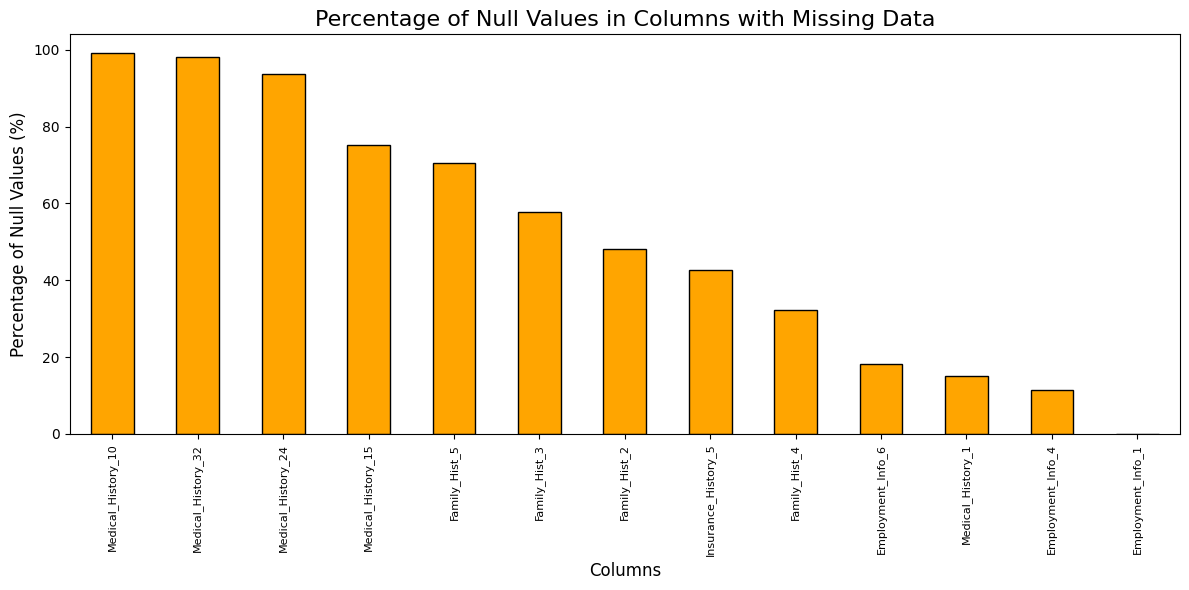

In [ ]:
null_percentage = df.isnull().mean() * 100

null_percentage_sorted = null_percentage.sort_values(ascending=False)
null_columns = null_percentage[null_percentage > 0]

# Lấy ra và sắp xếp các cột bị Null theo thứ tự giảm dần
null_columns_sorted = null_columns.sort_values(ascending=False)

# Vẽ biểu đồ tỉ lệ các cột bị Null
plt.figure(figsize=(12, 6))
null_columns_sorted.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Percentage of Null Values in Columns with Missing Data', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Percentage of Null Values (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Drop các cột bị missing value trên 60%
df.drop(['Medical_History_10','Medical_History_32','Medical_History_24','Medical_History_15','Family_Hist_5','Product_Info_2'],axis=1,inplace=True)

In [ ]:
# Drop các dòng với cột bị missing value dưới 5%
df.dropna(subset=['Employment_Info_1'],inplace=True)

In [ ]:
# Đếm số lượng Null trong các cột
features_with_nulls = {k:v for k, v in df.isnull().apply(sum).to_dict().items() if v > 0}
features_with_nulls

{'Employment_Info_4': 6775,
 'Employment_Info_6': 10848,
 'Insurance_History_5': 25383,
 'Family_Hist_2': 28641,
 'Family_Hist_3': 34233,
 'Family_Hist_4': 19170,
 'Medical_History_1': 8884}

In [ ]:
def loosen_limits(ax, which='x'):
    if which == 'x' or which == 'xy':
        x0, x1 = ax.get_xlim()
        xr = x1 - x0
        ax.set_xlim(x0 - 0.05 *xr, x1 + 0.05 * xr)
    elif  which == 'y' or which == 'xy':
        y0, y1 = ax.get_ylim()
        yr = y1 - y0
        ax.set_ylim(y0 - 0.05 *yr, y1 + 0.05 * yr)

def make_hist(df, cols, ylog=False):
    ysize = (len(cols) // 5 + 1) * 3.
    ax = df[cols].hist(figsize=(16,ysize), bins=50, sharex=False, layout=(-1,5))
    for axes in ax.flat:
        loosen_limits(axes)
        name = axes.get_title()
        if name == '':
            continue

        axes.set_title("{} [{:d}]".format(name, df[name].count()), fontsize=10)
        if ylog:
            axes.set_yscale('log')

def make_hexbin(df, col):
    ax = df.plot(kind='hexbin', x=col, y='Response', sharex=False, gridsize=25, norm=plt.colors.PowerNorm(1/2))
    ax.set_ylim(0., 9)
    loosen_limits(ax)
    ax.set_title(col, fontsize=10)
    return ax

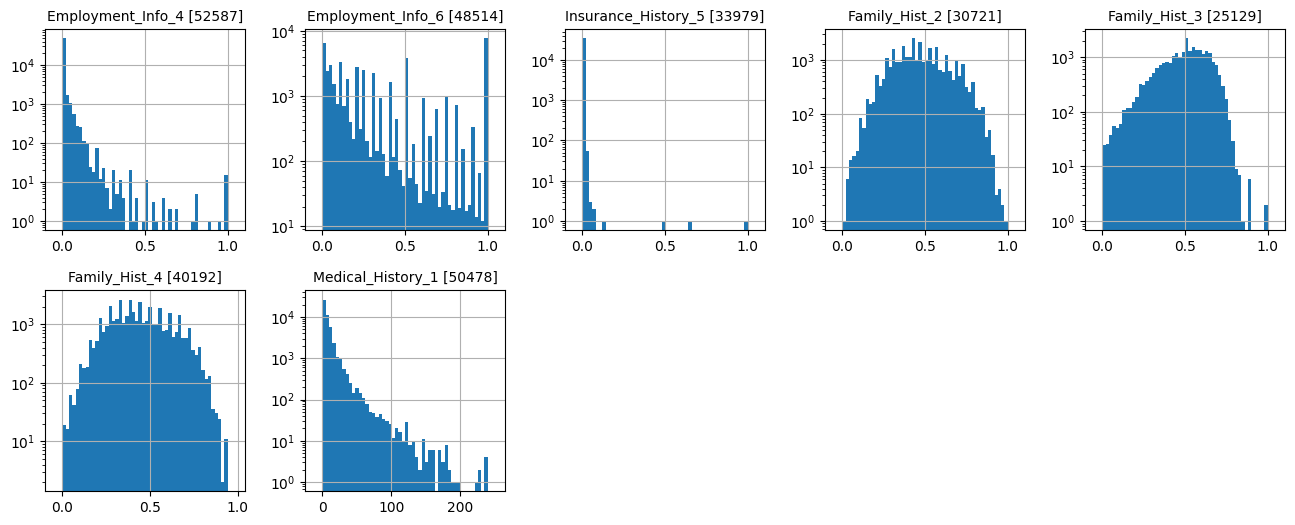

In [ ]:
na_cols = list(features_with_nulls.keys())
make_hist(df, na_cols, ylog=True)

Thay thế giá trị null bằng giá trị trung vị cho các cột Employment_Info_4, Employment_Info_6, Insurance_History_5, Medical_History_1:

In [ ]:
columns_median = df[['Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 'Medical_History_1']]
columns_mean = df[['Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4']]

# Thay thế giá trị null cho các cột phân phối không đều bằng median
for col in columns_median:
    df[col].fillna(df[col].median(), inplace=True)

# Thay thế giá trị null cho các cột phân phối chuẩn bằng mean
for col in columns_mean:
    df[col].fillna(df[col].mean(), inplace=True)

In [ ]:
df.isnull().sum().sum()

0

## Feature Engineering

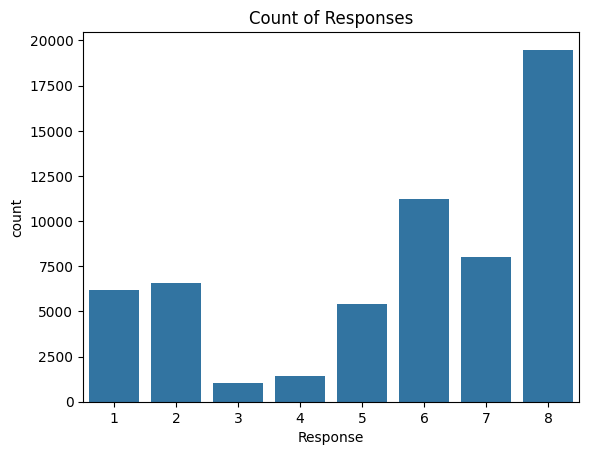

In [ ]:
sns.countplot(x=df['Response'])
plt.title('Count of Responses')
plt.show()

In [ ]:
df['Modified_Response']  = df['Response'].apply(lambda x : 0 if x<=5 and x>=0 else (1 if x <= 7 else 2))

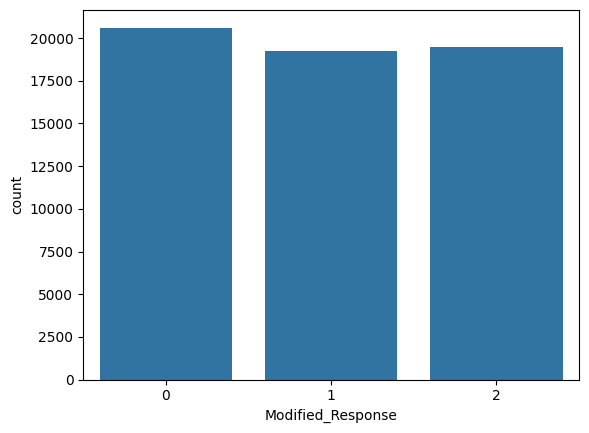

In [ ]:
sns.countplot(x=df['Modified_Response'])
plt.show()

In [ ]:
df.drop('Response',axis=1,inplace=True)

In [ ]:
df['BMI_Age'] = df['BMI'] * df['Ins_Age']

In [ ]:
df[['Id', 'BMI', 'Ins_Age', 'BMI_Age']].head(10)

,Id,BMI,Ins_Age,BMI_Age
0,2,0.323008,0.641791,0.207304
1,5,0.272288,0.059701,0.016256
2,6,0.428780,0.029851,0.012799
3,7,0.352438,0.164179,0.057863
4,8,0.424046,0.417910,0.177213
5,10,0.364887,0.507463,0.185166
6,11,0.376587,0.373134,0.140517
7,14,0.571612,0.611940,0.349792
8,15,0.362643,0.522388,0.189440
9,16,0.587796,0.552239,0.324604


In [ ]:
df['Med_keyword_count'] = df.filter(like='Medical_Keyword').sum(axis=1)

In [ ]:
df[['Id','Med_keyword_count']].sample(10)

,Id,Med_keyword_count
46183,61431,1
763,1029,0
16335,21747,2
12672,16829,1
6156,8201,0
2938,3914,1
2509,3345,2
56412,75167,0
7177,9571,1
42106,55946,2


In [ ]:
corr = df.corr()
corr_greater_than_50 = corr[corr>=.5]

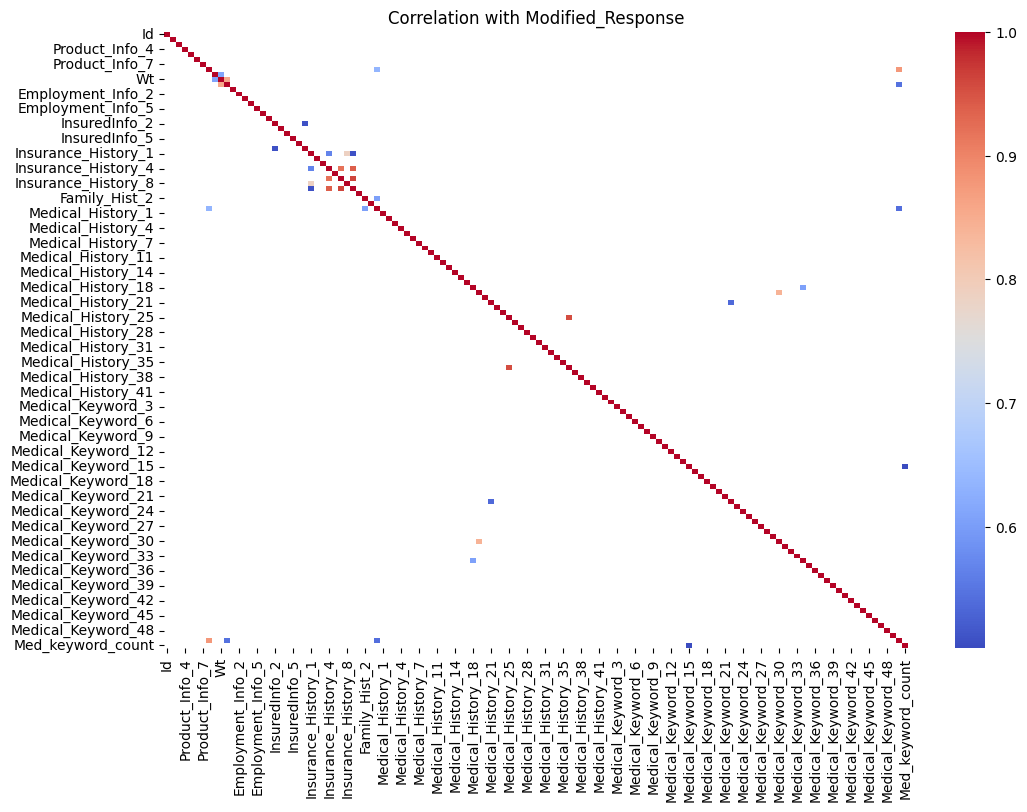

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_greater_than_50, cmap="coolwarm");
plt.title('Correlation with Modified_Response')
plt.show()

In [ ]:
correlation1 = df.corr()
response_correlation1 = correlation1[['Modified_Response']].sort_values(by='Modified_Response', ascending=False)
response_correlation_filtered = response_correlation1[response_correlation1['Modified_Response'] >= 0]

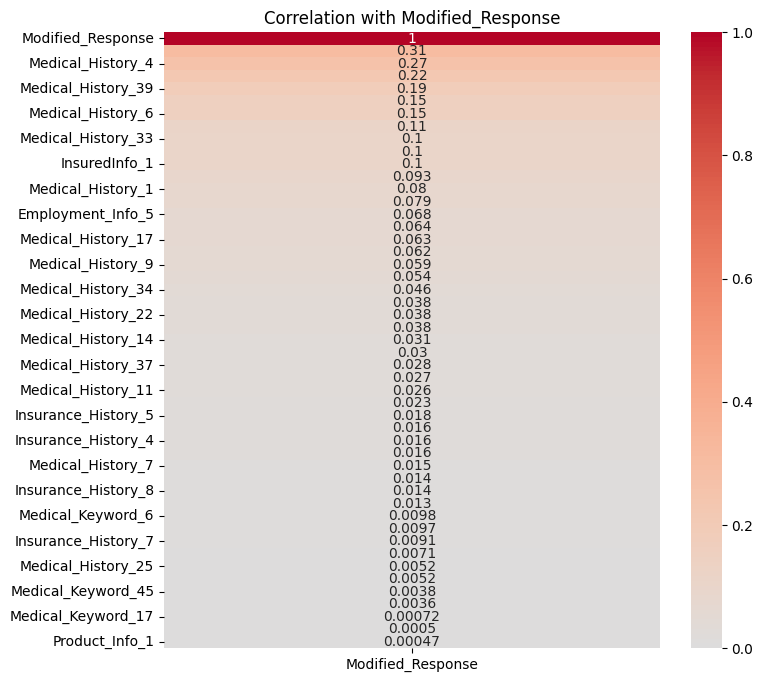

In [ ]:
# Tạo biểu đồ nhiệt
plt.figure(figsize=(8, 8))
sns.heatmap(response_correlation_filtered, annot=True, cmap='coolwarm', vmin=0, vmax=1, center=0)

# Cấu hình biểu đồ
plt.title('Correlation with Modified_Response')
plt.show()

In [ ]:
X= df.drop('Modified_Response',axis=1)
y= df['Modified_Response']

## Building ML Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Áp dụng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

# Tính toán các chỉ số khác
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# In các chỉ số
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.6746588803414004
Precision: 0.6749344003240045
Recall: 0.6759485696905044
F1 Score: 0.6716426823427198
ROC AUC: 0.8477276467572216


In [ ]:
feature_names=df.columns

                Feature  Importance
10                  BMI    0.106832
9                    Wt    0.073157
121             BMI_Age    0.054448
3        Product_Info_4    0.052356
0                    Id    0.037373
..                  ...         ...
116  Medical_Keyword_44    0.000520
118  Medical_Keyword_46    0.000454
85   Medical_Keyword_13    0.000435
69   Medical_History_38    0.000383
66   Medical_History_35    0.000125

[123 rows x 2 columns]


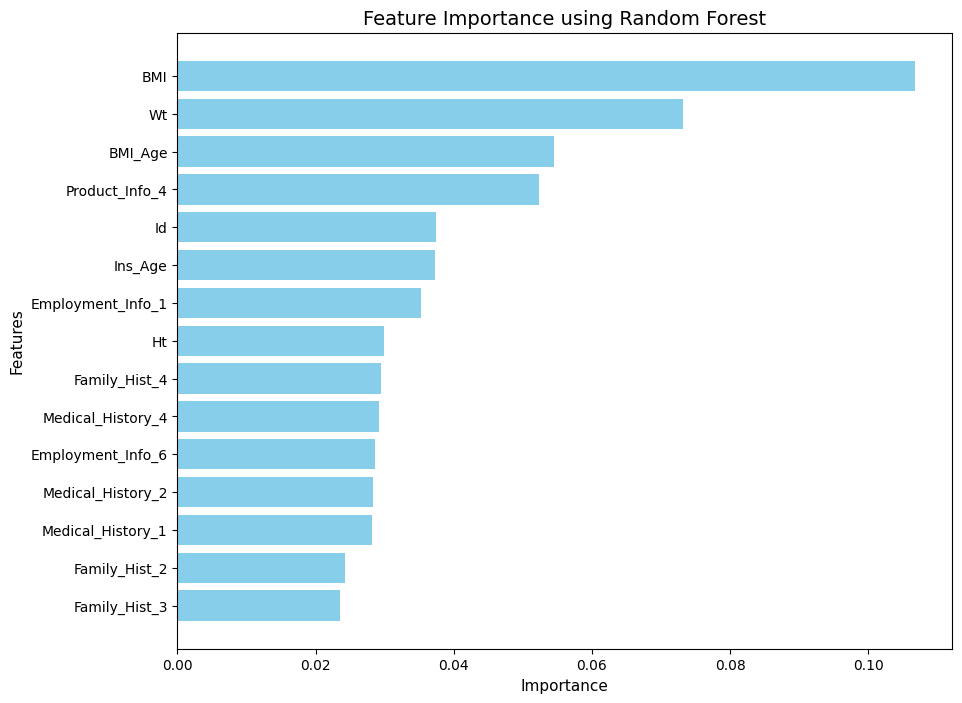

In [ ]:
# Lấy tầm quan trọng của các đặc trưng
feature_importances = model.feature_importances_
# Chuyển sang DataFrame để dễ xử lý
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Hiển thị danh sách tầm quan trọng của các đặc trưng
print(importance_df)

importance_df = importance_df.head(15)
# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Đảo ngược trục y để đặc trưng quan trọng nhất ở trên cùng
plt.xlabel('Importance',fontsize=11)
plt.ylabel('Features',fontsize=11)
plt.title('Feature Importance using Random Forest',fontsize=14)
plt.show()

In [ ]:
threshold = 0.01
important_features = importance_df[importance_df['Importance'] > threshold]

# Lọc X chỉ với các đặc trưng quan trọng
X_important = X[important_features['Feature']]

# In ra số lượng đặc trưng còn lại
print(f"Số lượng đặc trưng quan trọng: {X_important.shape[1]}")

Số lượng đặc trưng quan trọng: 15


In [ ]:
# In ra tên các đặc trưng còn lại
print("\nCác đặc trưng quan trọng (tầm quan trọng > 0.01):")
print(important_features['Feature'].tolist())


Các đặc trưng quan trọng (tầm quan trọng > 0.01):
['BMI', 'Wt', 'BMI_Age', 'Product_Info_4', 'Id', 'Ins_Age', 'Employment_Info_1', 'Ht', 'Family_Hist_4', 'Medical_History_4', 'Employment_Info_6', 'Medical_History_2', 'Medical_History_1', 'Family_Hist_2', 'Family_Hist_3']


In [ ]:
features=['BMI', 'Wt', 'BMI_Age', 'Product_Info_4', 'Ins_Age', 'Employment_Info_1', 'Ht', 'Family_Hist_4', 'Medical_History_4',
          'Employment_Info_6', 'Medical_History_2', 'Medical_History_1', 'Family_Hist_2', 'Family_Hist_3', 'Insurance_History_5',
          'Medical_History_23', 'InsuredInfo_3', 'Med_keyword_count', 'Medical_Keyword_15', 'Employment_Info_2', 'InsuredInfo_6',
          'Medical_Keyword_3','Medical_History_4']

In [ ]:
df_filtered = df[features]

In [ ]:
df_filtered.describe()

,BMI,Wt,BMI_Age,Product_Info_4,Ins_Age,Employment_Info_1,Ht,Family_Hist_4,Medical_History_4,Employment_Info_6,Medical_History_2,Medical_History_1,Family_Hist_2,Family_Hist_3,Insurance_History_5,Medical_History_23,InsuredInfo_3,Med_keyword_count,Medical_Keyword_15,Employment_Info_2,InsuredInfo_6,Medical_Keyword_3,Medical_History_4
count,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000,59362.000000
mean,0.469457,0.292581,0.193681,0.328958,0.405527,0.077582,0.707278,0.444905,1.654931,0.341077,253.993481,7.370641,0.474562,0.497730,0.001408,2.528301,5.835905,1.264445,0.190374,8.643358,1.409218,0.049207,1.654931
std,0.122216,0.089042,0.111483,0.282563,0.197160,0.082347,0.074241,0.134136,0.475395,0.318920,178.624362,12.097547,0.111478,0.091198,0.005565,0.849054,2.674438,1.480014,0.392600,4.226199,0.491694,0.216301,0.475395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,0.385517,0.225941,0.104257,0.076923,0.238806,0.035000,0.654545,0.380282,1.000000,0.100000,112.000000,2.000000,0.449275,0.497730,0.000667,3.000000,3.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000
50%,0.451349,0.288703,0.183606,0.230769,0.402985,0.060000,0.709091,0.444905,2.000000,0.250000,162.000000,4.000000,0.474562,0.497730,0.000973,3.000000,6.000000,1.000000,0.000000,9.000000,1.000000,0.000000,2.000000
75%,0.532858,0.345188,0.267702,0.487179,0.567164,0.100000,0.763636,0.492958,2.000000,0.500000,418.000000,8.000000,0.474562,0.497730,0.001273,3.000000,8.000000,2.000000,0.000000,9.000000,2.000000,0.000000,2.000000
max,1.000000,1.000000,0.805970,1.000000,1.000000,1.000000,1.000000,0.943662,2.000000,1.000000,648.000000,240.000000,1.000000,1.000000,1.000000,3.000000,11.000000,16.000000,1.000000,38.000000,2.000000,1.000000,2.000000


In [ ]:

# 1. Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(df_filtered, y, test_size=0.3, random_state=42, stratify=y)

# 2. Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Định nghĩa các tham số cho GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Hệ số điều chỉnh phạt L2
    'solver': ['liblinear', 'lbfgs'],  # Thuật toán tối ưu
    'penalty': ['l2'],  # Sử dụng phạt L2
    'max_iter': [100, 200, 500]  # Số vòng lặp tối đa
}

# 4. Cấu hình GridSearchCV với Logistic Regression
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Sử dụng tất cả các lõi CPU
                           verbose=2,  # In ra thông tin chi tiết
                           scoring='accuracy')  # Tiêu chí đánh giá là accuracy

# 5. Huấn luyện GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# 6. In ra tham số tối ưu
print("Best parameters found: ", grid_search.best_params_)

# 7. Dự đoán và đánh giá mô hình với tham số tối ưu
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
y_prob = grid_search.best_estimator_.predict_proba(X_test_scaled)  # Dự đoán xác suất cho mỗi lớp

# 8. Tính toán các chỉ số
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# 9. In các chỉ số
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.6021112920433489
Precision: 0.5921481601555455
Recall: 0.6009926197113385
F1 Score: 0.5894475291175006
ROC AUC: 0.7879236889836866


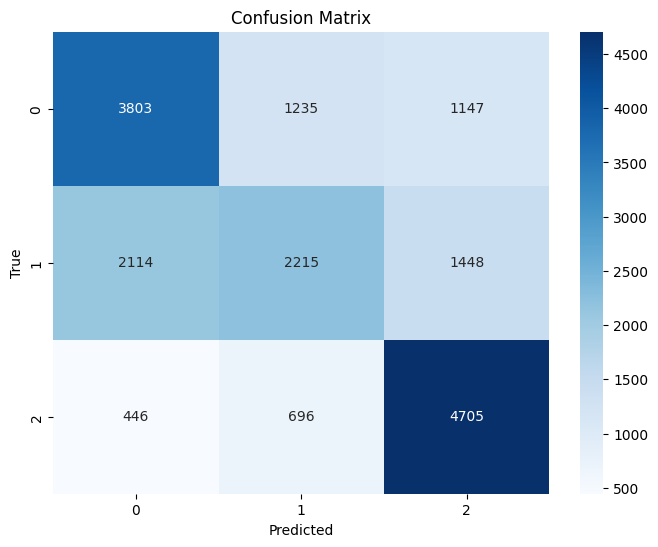

In [ ]:
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# In báo cáo chi tiết các lớp
report = classification_report(y_test, y_pred)
print("Đánh giá chi tiết các lớp:")
print(report)

Đánh giá chi tiết các lớp:
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      6185
           1       0.53      0.38      0.45      5777
           2       0.64      0.80      0.72      5847

    accuracy                           0.60     17809
   macro avg       0.59      0.60      0.59     17809
weighted avg       0.59      0.60      0.59     17809



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered, y, test_size=0.3, random_state=42)

In [ ]:
# Áp dụng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Huấn luyện mô hình Random Forest
model = RandomForestClassifier(random_state=42)

In [ ]:
# Định nghĩa các tham số grid search
param_grid = {
    'n_estimators': [1000],  # Số lượng cây
    'max_depth': [10, 20, None],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],  # Số mẫu tối thiểu để chia một node
    'min_samples_leaf': [1, 2, 4],  # Số mẫu tối thiểu để tạo lá

}

# Cấu hình GridSearchCV với 5 lần gấp dữ liệu (5-fold cross-validation)
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # 5-fold cross-validation
                           n_jobs=-1,  # Sử dụng tất cả các lõi CPU
                           verbose=2,  # In ra thông tin chi tiết
                           scoring='accuracy')  # Tiêu chí đánh giá là accuracy

# Huấn luyện GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# In ra tham số tối ưu
print("Best parameters found: ", grid_search.best_params_)

# Dự đoán và đánh giá mô hình với tham số tối ưu
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
y_prob = grid_search.best_estimator_.predict_proba(X_test_scaled)  # Dự đoán xác suất cho mỗi lớp

# Tính toán các chỉ số
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# In các chỉ số
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Accuracy: 0.6618002133752597
Precision: 0.6636315370595308
Recall: 0.6635527157964384
F1 Score: 0.6581050603950513
ROC AUC: 0.8364105965516532


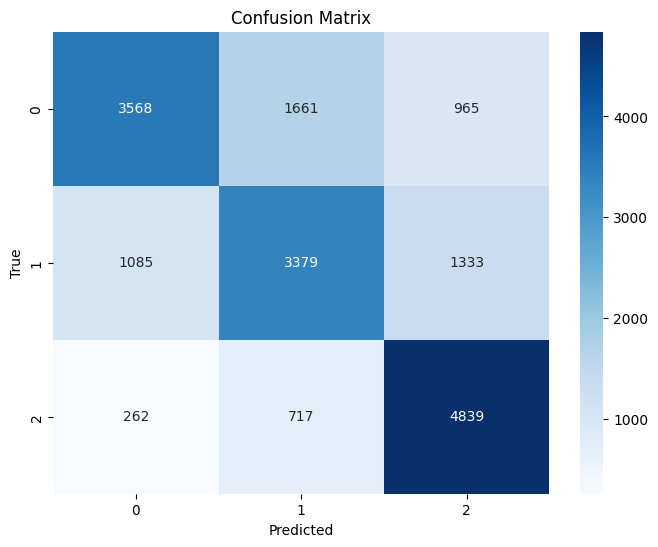

In [ ]:
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# In báo cáo chi tiết các lớp
report = classification_report(y_test, y_pred)
print("Đánh giá chi tiết các lớp:")
print(report)

Đánh giá chi tiết các lớp:
              precision    recall  f1-score   support

           0       0.73      0.58      0.64      6194
           1       0.59      0.58      0.58      5797
           2       0.68      0.83      0.75      5818

    accuracy                           0.66     17809
   macro avg       0.66      0.66      0.66     17809
weighted avg       0.67      0.66      0.66     17809

